In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import pandas as pd
import numpy as np

import ast
import os
import wget
import pickle

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 1. Dataset

In [7]:
train = pd.read_csv('Seah_data_table.csv')
train.head()

,file_name,div,steel_grade,lot_no,GS,mix,mGS,TS,YS,RA,EL,min_con,max_con,avg_con,cnt_con,std_con,med_con
0,A-100_STS304CUS4 B3B0544800 X100 G.S=5.png,A,STS304CUS4,B3B0544800,5.0,X,-,460.0,180.0,45.0,81.0,9.0,16720.5,3999.614035,57,4015.571470,2610.00
1,A-101_STS304CUMS4 B410066807 X100 G.S=6.5.png,A,STS304CUMS4,B410066807,6.5,X,-,475.0,165.0,51.0,81.0,0.0,8146.0,1482.176056,142,1909.096088,695.00
2,A-102_S30432S1 B41P007800 X100 G.S=9.png,A,S30432S1,B41P007800,9.0,X,-,635.0,350.0,49.0,NaN,0.0,1735.5,136.678571,924,185.485984,76.25
3,A-103_S304THES3 B320715101 X100 G.S =4.png,A,S304THES3,B320715101,4.0,X,-,640.0,360.0,47.0,80.0,4.5,30210.0,3530.253846,65,5463.759725,1529.00
4,A-104_S304J3S2 B3C0494500 X100 G.S= 5.png,A,S304J3S2,B3C0494500,5.0,X,-,545.0,220.0,65.0,82.0,0.0,17504.5,2511.295455,88,3214.912795,1319.50


In [8]:
train.drop('file_name', axis=1, inplace=True)
train.drop('mGS', axis=1, inplace=True)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, 0 to 1041
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   div          975 non-null    object 
 1   steel_grade  975 non-null    object 
 2   lot_no       975 non-null    object 
 3   GS           975 non-null    float64
 4   mix          975 non-null    object 
 5   TS           975 non-null    float64
 6   YS           975 non-null    float64
 7   RA           975 non-null    float64
 8   EL           975 non-null    float64
 9   min_con      975 non-null    float64
 10  max_con      975 non-null    float64
 11  avg_con      975 non-null    float64
 12  cnt_con      975 non-null    int64  
 13  std_con      975 non-null    float64
 14  med_con      975 non-null    float64
dtypes: float64(10), int64(1), object(4)
memory usage: 121.9+ KB


# 2. Preprocessing

In [9]:
target = ['TS', 'YS', 'RA', 'EL']

if "Set" not in train.columns:
    train = train.reset_index(drop=True)
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
train.head()

,div,steel_grade,lot_no,GS,mix,TS,YS,RA,EL,min_con,max_con,avg_con,cnt_con,std_con,med_con,Set
0,A,STS304CUS4,B3B0544800,5.0,X,460.0,180.0,45.0,81.0,9.0,16720.5,3999.614035,57,4015.571470,2610.0,train
1,A,STS304CUMS4,B410066807,6.5,X,475.0,165.0,51.0,81.0,0.0,8146.0,1482.176056,142,1909.096088,695.0,train
2,A,S304THES3,B320715101,4.0,X,640.0,360.0,47.0,80.0,4.5,30210.0,3530.253846,65,5463.759725,1529.0,train
3,A,S304J3S2,B3C0494500,5.0,X,545.0,220.0,65.0,82.0,0.0,17504.5,2511.295455,88,3214.912795,1319.5,test
4,A,S304J3S2,B3C0494500,5.0,X,545.0,220.0,65.0,82.0,0.0,20425.0,2499.500000,89,3580.757135,1236.5,train


In [10]:
categorical_columns = []
categorical_dims =  {}
encoders = {}
l_enc = LabelEncoder()
for col in train.columns[train.dtypes == object]:
    if col != 'img_vec' and col != 'mask_vec':
        print(col, train[col].nunique())
        train[col] = l_enc.fit_transform(train[col].values)
        encoders[col] = LabelEncoder()
        encoders[col].classes_ = l_enc.classes_  # 각 컬럼마다 클래스 복사
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
train.info()

div 4
steel_grade 39
lot_no 249
mix 2
Set 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   div          975 non-null    int64  
 1   steel_grade  975 non-null    int64  
 2   lot_no       975 non-null    int64  
 3   GS           975 non-null    float64
 4   mix          975 non-null    int64  
 5   TS           975 non-null    float64
 6   YS           975 non-null    float64
 7   RA           975 non-null    float64
 8   EL           975 non-null    float64
 9   min_con      975 non-null    float64
 10  max_con      975 non-null    float64
 11  avg_con      975 non-null    float64
 12  cnt_con      975 non-null    int64  
 13  std_con      975 non-null    float64
 14  med_con      975 non-null    float64
 15  Set          975 non-null    int64  
dtypes: float64(10), int64(6)
memory usage: 122.0 KB


In [11]:
with open("./model/tabnet_encoder.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [12]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+target] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

cat_emb_dim = [2, 19, 50, 1, 50, 2]
cat_emb_dim = [2, 19, 50, 1]
cat_idxs, cat_dims

([0, 1, 2, 4], [4, 39, 249, 2])

# 3. Network

In [13]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs, device_name='cuda')

/home/song/Desktop/GS-Prediction/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# 4. Training

In [14]:
features, target

(['div',
  'steel_grade',
  'lot_no',
  'GS',
  'mix',
  'min_con',
  'max_con',
  'avg_con',
  'cnt_con',
  'std_con',
  'med_con'],
 ['TS', 'YS', 'RA', 'EL'])

In [15]:
print(features)

['div', 'steel_grade', 'lot_no', 'GS', 'mix', 'min_con', 'max_con', 'avg_con', 'cnt_con', 'std_con', 'med_con']


In [16]:
n_targets = 4

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
# y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
# y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
# y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [17]:
with open('./model/trained_columns.pkl', 'wb') as f:
    pickle.dump(features, f)

In [18]:
X_train.shape, y_train.shape

((778, 11), (778, 4))

In [19]:
X_valid.shape, y_valid.shape

((109, 11), (109, 4))

In [20]:
X_test.shape, y_test.shape

((88, 11), (88, 4))

In [21]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

clf.fit(
    X_train=X_train, 
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: 100312.41406| train_rmsle: 4.79752 | train_mae: 240.00239| train_rmse: 316.09276| train_mse: 99914.63608| valid_rmsle: 4.82362 | valid_mae: 240.20942| valid_rmse: 316.4089| valid_mse: 100114.5944|  0:00:00s
epoch 1  | loss: 100144.32812| train_rmsle: 4.8125  | train_mae: 239.7397| train_rmse: 315.99741| train_mse: 99854.36534| valid_rmsle: 4.81683 | valid_mae: 239.95338| valid_rmse: 316.36681| valid_mse: 100087.95963|  0:00:00s
epoch 2  | loss: 100028.95312| train_rmsle: 4.75246 | train_mae: 239.42442| train_rmse: 315.79455| train_mse: 99726.19612| valid_rmsle: 4.74557 | valid_mae: 240.14037| valid_rmse: 316.33766| valid_mse: 100069.51278|  0:00:00s
epoch 3  | loss: 99909.00781| train_rmsle: 4.65159 | train_mae: 239.0514| train_rmse: 315.47419| train_mse: 99523.96524| valid_rmsle: 4.6444  | valid_mae: 239.17535| valid_rmse: 315.64398| valid_mse: 99631.12254|  0:00:00s
epoch 4  | loss: 99772.23438| train_rmsle: 4.5522  | train_mae: 238.62325| train_rmse: 315.08005| trai

/home/song/Desktop/GS-Prediction/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [22]:
history = clf.history
print("Available keys in history:", history.history.keys())

Available keys in history: dict_keys(['loss', 'lr', 'train_rmsle', 'train_mae', 'train_rmse', 'train_mse', 'valid_rmsle', 'valid_mae', 'valid_rmse', 'valid_mse'])


In [23]:
train_loss = history.history['loss']  # 학습 손실
train_mse = history.history['train_mse']  # 학습 데이터 MSE
valid_mse = history.history['valid_mse']  # 검증 데이터 MSE
epochs = range(1, len(train_loss) + 1)

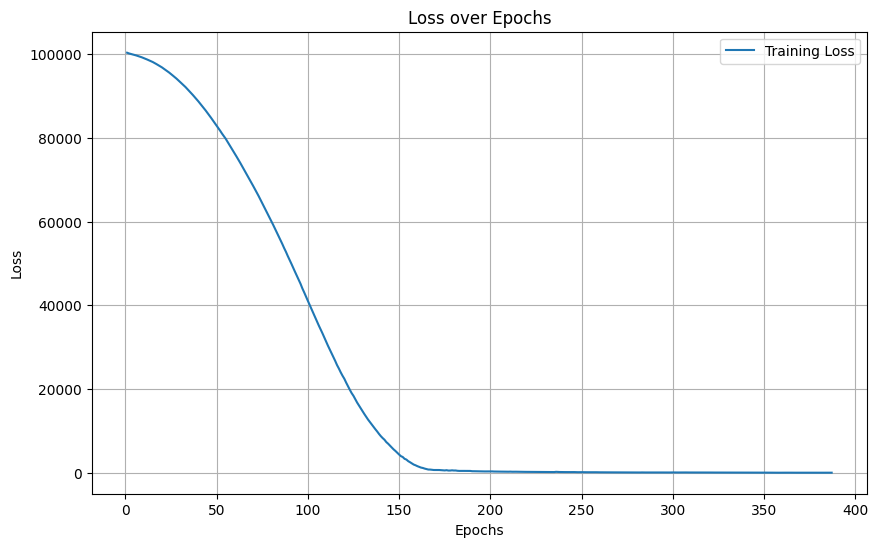

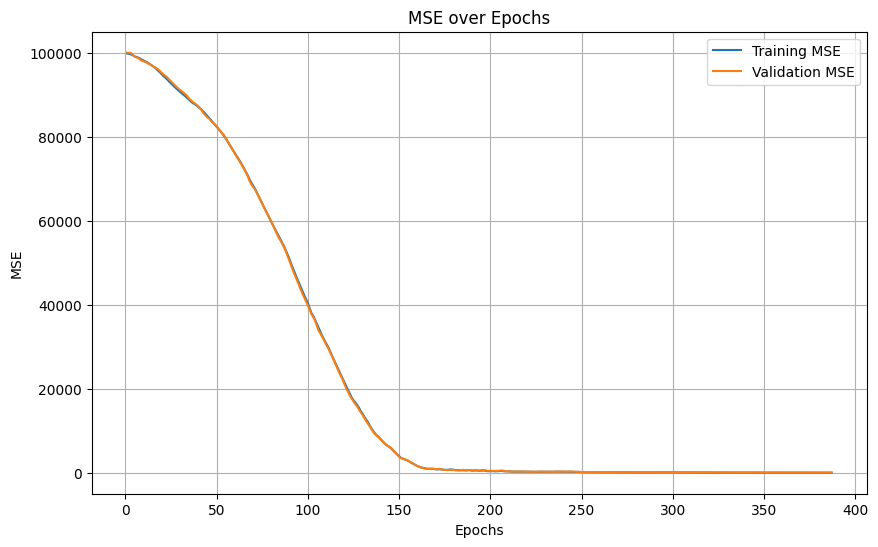

MAPE SCORE FOR Seah-data : 0.03545127170269858


In [24]:
# 손실(Loss) 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# MSE 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mse, label='Training MSE')
plt.plot(epochs, valid_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

dataset_name = 'Seah-data'
preds = clf.predict(X_test)
test_mape = mean_absolute_percentage_error(y_pred=preds, y_true=y_test)
print(f"MAPE SCORE FOR {dataset_name} : {test_mape}")

# 5. Test

In [25]:
dataset_name = 'Seah-data'
preds = clf.predict(X_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_mse}")

BEST VALID SCORE FOR Seah-data : 81.94066207119452
FINAL TEST SCORE FOR Seah-data : 68.58429790294737


In [26]:
test_mape = mean_absolute_percentage_error(y_pred=preds, y_true=y_test)
print(f"MAPE SCORE FOR {dataset_name} : {test_mape}")

MAPE SCORE FOR Seah-data : 0.03545127170269858


In [28]:
clf.save_model("assets/tabnet_model")

Successfully saved model at assets/tabnet_model.zip


'assets/tabnet_model.zip'

# 6. Result

In [39]:
explain_matrix, masks = clf.explain(X_test)

In [40]:
train[features]

,div,steel_grade,lot_no,GS,mix,min_con,max_con,avg_con,cnt_con,std_con,med_con
0,0,21,45,5.0,1,9.0,16720.5,3999.614035,57,4015.571470,2610.0
1,0,19,94,6.5,1,0.0,8146.0,1482.176056,142,1909.096088,695.0
2,0,16,3,4.0,1,4.5,30210.0,3530.253846,65,5463.759725,1529.0
3,0,15,89,5.0,1,0.0,17504.5,2511.295455,88,3214.912795,1319.5
4,0,15,89,5.0,1,0.0,20425.0,2499.500000,89,3580.757135,1236.5
...,...,...,...,...,...,...,...,...,...,...,...
970,3,7,232,5.0,1,0.0,10975.5,1422.844961,129,2137.954084,436.0
971,3,7,152,2.0,1,2.0,118394.0,11734.500000,20,26582.519070,2076.0
972,3,1,114,5.5,1,0.0,12262.0,2352.337349,83,2436.660211,1690.5
973,3,1,114,5.5,1,8.0,10183.5,2338.904762,84,2441.658017,1542.0


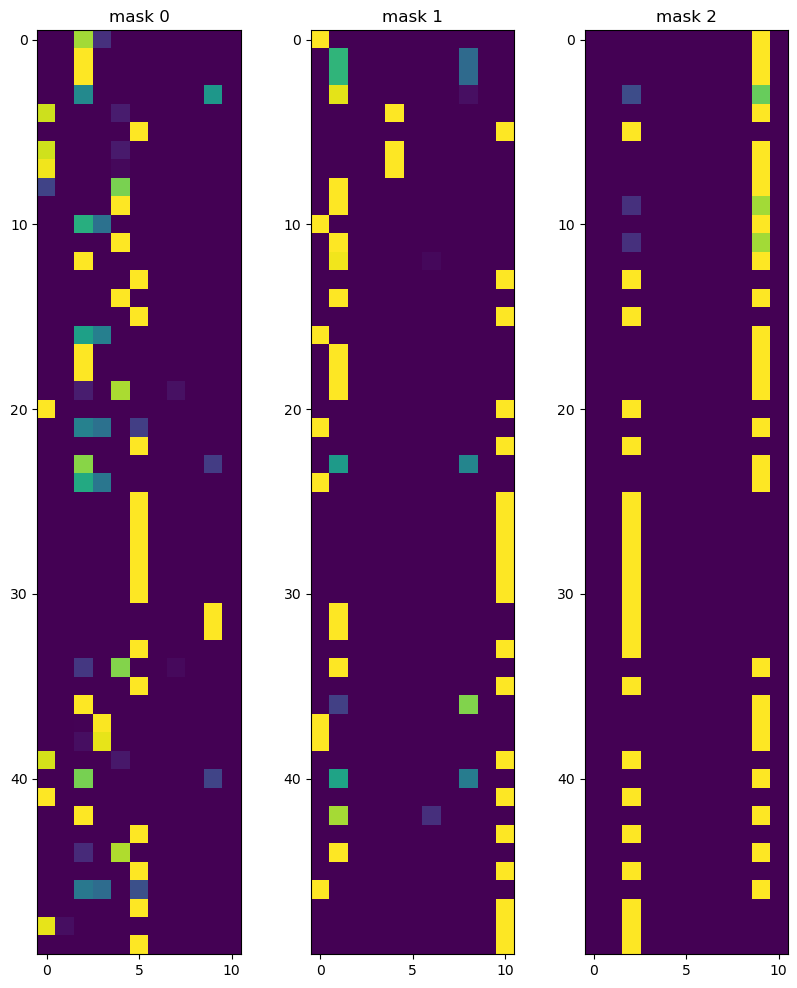

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(10,12))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

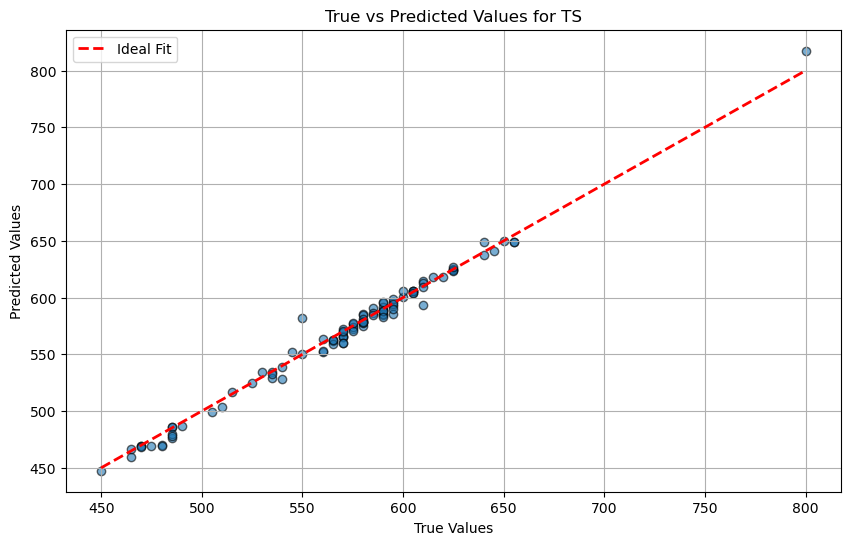

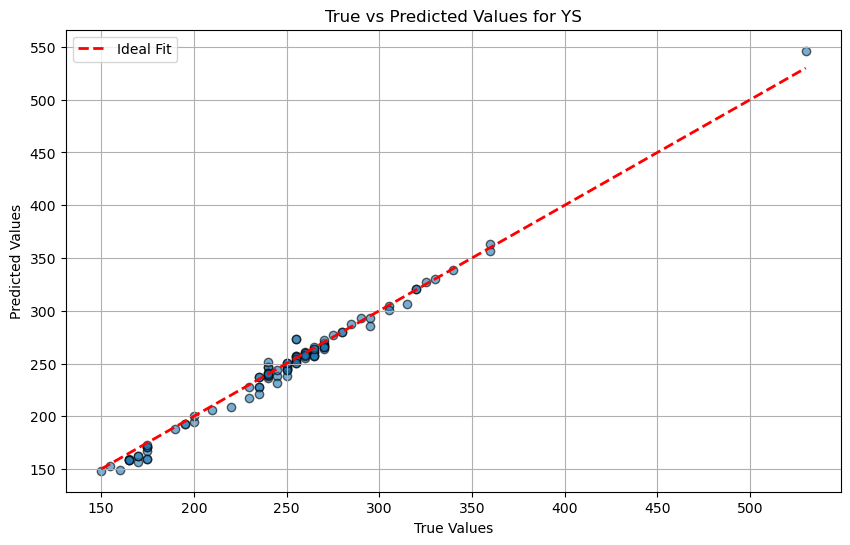

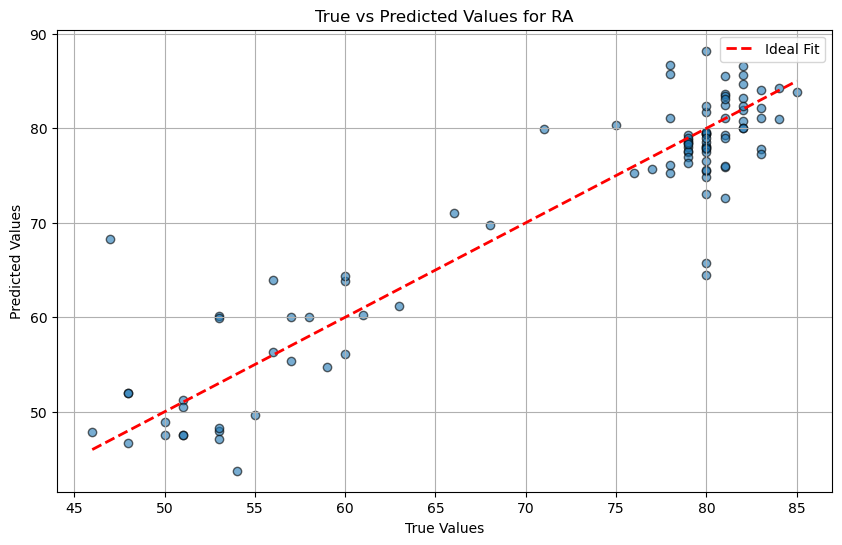

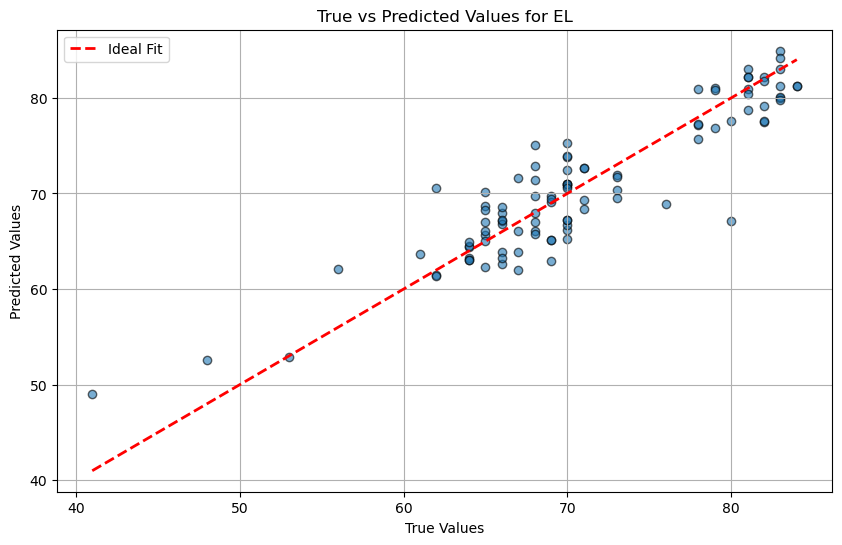

In [42]:
target_columns = ['TS', 'YS', 'RA', 'EL']

for i, target in enumerate(target_columns):
    # True vs Predicted Values for each target
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[:, i], preds[:, i], alpha=0.6, edgecolors='k')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], 
             [y_test[:, i].min(), y_test[:, i].max()], 'r--', lw=2, label='Ideal Fit')
    plt.title(f'True vs Predicted Values for {target}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

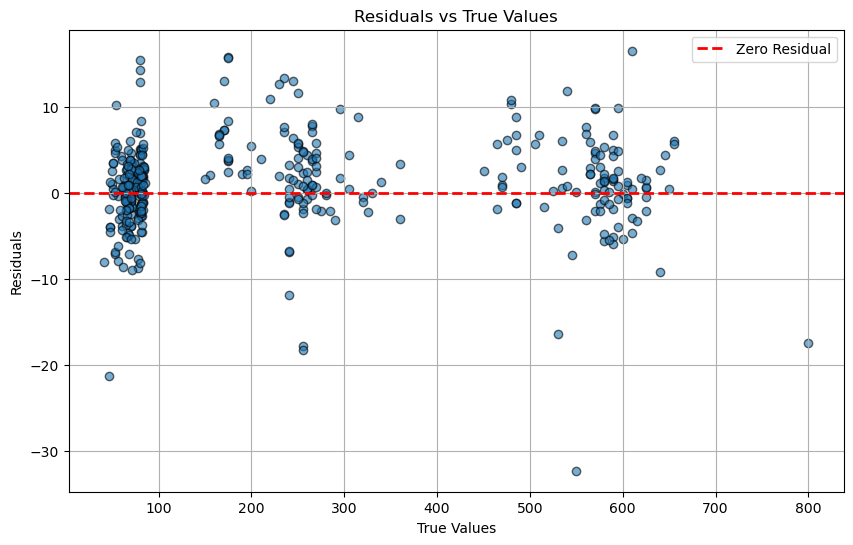

In [43]:
# Residual plot (errors vs true values)
residuals = y_test - preds
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2, label='Zero Residual')
plt.title('Residuals vs True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

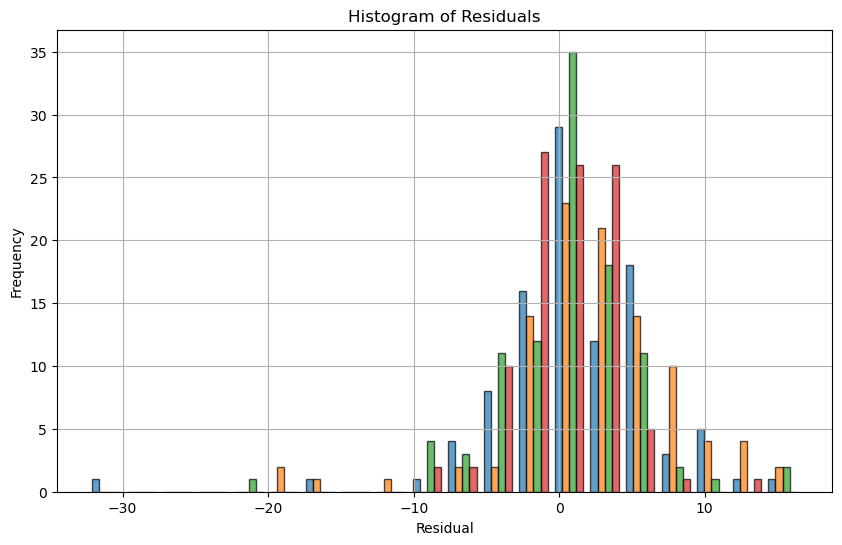

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()